In [0]:
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Sampler


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from os import listdir
from os.path import isfile, join
import time
import copy

from PIL import Image

#Skitlearn
from sklearn.metrics import confusion_matrix

#from efficientnet_pytorch import EfficientNet

plt.ion()   # interactive mode

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

PATH = "gdrive/My Drive/Semester_project/"
SUB_PATH =PATH + 'Datas/Ara/'
ANNOTATION_PATH = PATH + 'Datas/Ara/Annotations/'
DATA_PATH =   SUB_PATH + 'Images/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Preprocessing

### Converting filenames into CSV with lables 

Age dataset form [Here](https://susanqq.github.io/UTKFace/)
The labels of each face image is embedded in the file name, formated like 

[age]_[gender]_[race]_[date&time].jpg

In [0]:
df=pd.read_csv(ANNOTATION_PATH + 'labels.csv')
classes = df.stage.unique().size  

classes 

5

In [0]:
df.iloc[1, 1]

'BVZ0073-GC36R-RGB01~fullres-cor-T16-D4-35302_2016_10_02_08_00_00_00.jpg'

In [0]:
row = df.loc[df['filename'] == 'BVZ0073-GC36R-RGB01~fullres-cor-T16-D4-35302_2016_10_02_08_00_00_00.jpg'].iloc[0,0]

### Train - Test - Val split

### Weightening

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train = pd.read_csv(ANNOTATION_PATH +'train.csv')
distribution = train.stage.value_counts().sort_index()
distribution = distribution.to_numpy()
S = np.pad(distribution[::-1].cumsum()[::-1], (0,1))[1:]
N = np.full(distribution.size , fill_value = distribution.sum())
M = np.maximum(S, N-S)
importance = np.sqrt(M) / np.max(np.sqrt(M))
importance = torch.from_numpy(importance).to(device, dtype=torch.float)

In [0]:
im = Image.open(os.path.join(DATA_PATH, train.iloc[1,1]))
im1 = im.crop((train.loc[1,'x_min'], train.loc[1,'y_min'], train.loc[1,'x_max'], train.loc[1,'y_max'])) 

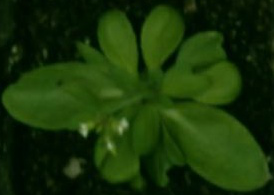

In [0]:
im1

## Get images 


### Dataset


In [0]:
class PlantDataset(Dataset):
  def __init__(self, 
               csv_file, 
               root_dir, 
               num_classes, 
               transform=None,
               crop=False):
      """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            crop (boulean) : Optional indicator to crop the image according to the bounding box 
        """

      self.data = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transform
      self.num_classes = num_classes
      self.crop = crop

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):

      if torch.is_tensor(idx):
          idx = idx.tolist()

      #Get image name 
      img_name = os.path.join(self.root_dir,
                                str(self.data.iloc[idx, 2]))
        
      image = Image.open(img_name)

      # Image cropping 
      if self.crop : 
        vect = (self.data.loc[idx,'x_min'], self.data.loc[idx,'y_min'],
                            self.data.loc[idx,'x_max'], self.data.loc[idx,'y_max'])
        image = image.crop(vect)
      
      # Get the label 
      labels = self.data.loc[idx, 'stage'] - 1

      # Apply the tranform 
      if self.transform:
          image = self.transform(image)
      return {'image': image,
                'labels': labels #label_tensor
                }


In [0]:
class PlantDatasetTest(Dataset):
  def __init__(self, 
               csv_file,
               all_file, 
               root_dir, 
               num_classes, 
               transform=None,
               crop=False):
      """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            crop (boulean) : Optional indicator to crop the image according to the bounding box 
        """

      self.data = pd.read_csv(csv_file)
      self.all_data = pd.read_csv(all_file)
      self.root_dir = root_dir
      self.transform = transform
      self.num_classes = num_classes
      self.crop = crop

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):

      if torch.is_tensor(idx):
          idx = idx.tolist()

      #Get image name 
      img_name = os.path.join(self.root_dir,
                                str(self.data.iloc[idx, 2]))
        
      image = Image.open(img_name)

      # Image cropping 
      if self.crop : 
        vect = (self.data.loc[idx,'x_min'], self.data.loc[idx,'y_min'],
                            self.data.loc[idx,'x_max'], self.data.loc[idx,'y_max'])
        image = image.crop(vect)
      try : 
        row = self.all_data.loc[self.all_data['filename'] == str(self.data.iloc[idx, 2])].iloc[0,0]
        neighbor = ((self.all_data.loc[row + 1 , 'stage'] == (self.all_data.loc[row  , 'stage'] + 1)) or 
                    (self.all_data.loc[row , 'stage'] == (self.all_data.loc[row + - 1 , 'stage'] + 1)))
      except: 
        neighbor = False

      # Get the label 
      labels = self.data.loc[idx, 'stage'] - 1

      # Apply the tranform 
      if self.transform:
          image = self.transform(image)
      return {'image': image,
                'labels': labels, #label_tensor,
              'neighbor' : neighbor, 
              'url' : img_name
                }


Load and finetune the model 


> Bloc en retrait



In [0]:
model_ft = models.resnet152(pretrained=True)

In [0]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, classes)

## Training and validation 


In [0]:
#Confusion matrix


In [0]:
def train_model(model, 
                data_loader, 
                criterion,
                optimizer, 
                scheduler, 
                num_epochs = 25):
  
    since = time.time()


    val_acc_history = []
    lr_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            sup_corrects = 0
            inf_corrects = 0
            confusion_matrix = torch.zeros(classes, classes)

            
            for bi, dl in enumerate(data_loader[phase]):
                inputs = dl["image"]
                labels = dl["labels"] 
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                # zero gradient
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data )

                # Confusion matrix 
                for t, p in zip(labels.view(-1), preds.view(-1)):
                  #print(t)
                  #print(p)
                  confusion_matrix[t.long(), p.long()] += 1                

                # Corect for neighbour classes 
                sup_corrects += torch.sum(preds == labels.data + 1)
                inf_corrects += torch.sum(preds == labels.data - 1)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            neighbor_acc = (sup_corrects.double() + inf_corrects.double())/ (2 * dataset_sizes[phase] )

            print('{} Loss: {:.4f} Acc: {:.4f} Neighbor acc : {:.4f}'.format(
                phase, epoch_loss, epoch_acc, neighbor_acc))
            
            # Print accuracy per class 
            print(confusion_matrix.diag()/confusion_matrix.sum(1))

            print(scheduler.get_last_lr())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                lr_history.append(scheduler.get_last_lr())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
IMAGE_SIZE = 224
NUM_CLASSES = classes
BATCH_SIZE = 32

learning_rate = 0.0005
num_epochs = 200


# Augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), (0.5, 1.) , (1,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


train_dataset = PlantDataset(csv_file=ANNOTATION_PATH + 'train.csv' ,
                                   root_dir=DATA_PATH,
                                   num_classes=NUM_CLASSES,
                                   transform=data_transforms['train'],
                                  crop= True)
val_dataset = PlantDataset(csv_file=ANNOTATION_PATH + 'val.csv',
                                   root_dir=DATA_PATH,
                                   num_classes=NUM_CLASSES,
                                   transform=data_transforms['val'], 
                                    crop=True)
image_datasets = {'train' : train_dataset , 
                  'val' : val_dataset}

train_dataset_loader = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, 
                                             shuffle=True, 
                                             num_workers=4), 
                        'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, 
                                             shuffle=False, num_workers=4)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [0]:
# push model to device
model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()


params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
#For resnet
plist = [
        {'params': model_ft.layer4.parameters(), 'lr': 1e-5},
        {'params': model_ft.fc.parameters(), 'lr': 5e-3}
        ]

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

ValueError: ignored

In [0]:
torch.cuda.empty_cache()

In [0]:
# Train and evaluate
model_ft, hist = train_model(model_ft, train_dataset_loader, criterion, optimizer, exp_lr_scheduler, num_epochs= 75)
torch.save(model_ft.state_dict(), "model.bin")

NameError: ignored

In [0]:

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,75+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, 75+1, 1.0))
plt.legend()
plt.show()

## Simulate for multiple 

In [0]:
IMAGE_SIZE = 224
NUM_CLASSES = classes
BATCH_SIZE = 32
learning_rate = 0.0005
num_epochs = 200



In [0]:

# Augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), (0.5, 1.) , (1,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# use the face dataset class

#Not super beautyful, need to refactor using data transform structure



In [0]:
# Augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((112, 112)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((126, 126)),
        transforms.CenterCrop((112,112)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [0]:
train_paths = [{'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test0.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train0.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val0.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test1.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train1.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val1.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test2.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train2.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val2.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test3.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train3.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val3.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test4.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train4.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val4.csv'}]

In [0]:
train = pd.read_csv(train_paths[1]['train'])

In [0]:
for i, path in enumerate(train_paths) : 
  #Importance
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  train = pd.read_csv(path['train'])
  distribution = train.stage.value_counts().sort_index()
  distribution = distribution.to_numpy()
  S = np.pad(distribution[::-1].cumsum()[::-1], (0,1))[1:]
  N = np.full(distribution.size , fill_value = distribution.sum())
  M = np.maximum(S, N-S)
  importance = np.sqrt(M) / np.max(np.sqrt(M))
  importance = torch.from_numpy(importance).to(device, dtype=torch.float)

# Dtatasets 
  train_dataset = PlantDataset(csv_file=path['train'] ,
                                    root_dir=DATA_PATH,
                                    num_classes=NUM_CLASSES,
                                    transform=data_transforms['train'],
                                    crop= False)
  val_dataset = PlantDataset(csv_file=path['val'],
                                    root_dir=DATA_PATH,
                                    num_classes=NUM_CLASSES,
                                    transform=data_transforms['val'], 
                                      crop=False)
  image_datasets = {'train' : train_dataset , 
                    'val' : val_dataset}

  train_dataset_loader = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              num_workers=4), 
                          'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, 
                                              shuffle=False, num_workers=4)}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  
  model_ft = models.resnet50(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, classes)

  model_ft = model_ft.to(device)


  criterion = nn.CrossEntropyLoss(importance)

  params = [p for p in model_ft.parameters() if p.requires_grad]
  optimizer_ft = optim.Adam(params, lr=0.005, weight_decay=0.0005)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

  model_ft, hist = train_model(model_ft, train_dataset_loader, criterion, optimizer_ft, exp_lr_scheduler, num_epochs= 40)
  save_path = SUB_PATH + 'model_classic_4' + str(i) + '.bin'

  torch.save(model_ft.state_dict(), save_path)


  ## Eval 



## Test

### Test for one 

In [0]:
# Compute the Cumulative score CS 
# With T = 1 -> Accuracy 

def CS(y_predict, y_true , T):
  x = np.abs(y_true - y_predict)
  x = np.where(x<= T, 1, 0)
  return np.average(x)

In [0]:
test_val = pd.read_csv(ANNOTATION_PATH + 'test.csv')
test_val = test_val['stage'].to_numpy()

In [0]:
test_val = test_val.astype(int)
test_val.size

413

In [0]:
color =  ['#ffffff', '#e6e9eb', '#cdd3d7', '#b4bec4', '#9ca9b1',
'#85949e', '#6e808c', '#576d7a', '#415a69', '#2a4858' ]

In [0]:
TEST_BATCH_SIZE = 128

# Augmentation 
test_transforms =  transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


In [0]:
acc = []
neib_acc = []
matrix = []
preds_values = []
true_values= []
imge = []
neighboring = []
for i, path in enumerate(train_paths) : 
  save_path = SUB_PATH + 'model_classic_3' + str(i) + '.bin'
  model_ft.load_state_dict(torch.load(save_path))

  test_dataset = PlantDatasetTest(csv_file=path['test'],
                                all_file=ANNOTATION_PATH + 'labels.csv',
                                   root_dir=DATA_PATH,
                                   num_classes=NUM_CLASSES,
                                   transform=data_transforms['val'],
                                  crop = False)

  test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=128,
                                             shuffle=False,
                                             num_workers=4)



  dataset_sizes = len(test_dataset)

  model_ft = model_ft.to(device)
  confusion_matrix = torch.zeros(classes, classes)
  id_matrix = torch.zeros(classes, classes)

  for param in model_ft.parameters():
      param.requires_grad = False

  model_ft.eval()
  test_preds = np.zeros((len(test_dataset)))
  test_val = np.zeros((len(test_dataset)))
  im = np.zeros((len(test_dataset), 3,224,224))
  neigh = np.zeros(len(test_dataset))

  for i, x_batch in enumerate(test_dataset_loader):
      x_image = x_batch["image"]
      labels = x_batch["labels"]
      n = x_batch['neighbor']
      pred = torch.argmax(model_ft(x_image.to(device)).sigmoid(), axis = 1) 

      for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1 
            id_matrix
      test_preds[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = pred.detach().cpu().squeeze().numpy()
      test_val[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = labels.numpy()
      im[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = x_image
      neigh[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = n

  test_preds = torch.from_numpy(test_preds).float().to(device).cpu().squeeze().numpy()
  matrix.append(confusion_matrix)
  preds_values.append(test_preds)
  true_values.append(torch.from_numpy(test_val).float().to(device).cpu().squeeze().numpy())
  acc.append(CS(test_preds, test_val, 0))
  imge.append(im)
  neib_acc.append(CS(test_preds, test_val, 1))
  neighboring.append(neigh)


print(acc)
print(neib_acc)
print(matrix)
for i, mat in enumerate(matrix): 
  print(mat)
  print(mat.diag() / mat.sum(1))

In [0]:
stats = []
tots = []
statistiquess  = []
totals = []
vecs = []
vects = []
class_vecs = []
false_class_vecs=[]

for SET in range(0,5):
  stat = 0
  tot = 0
  statistiques  = 0
  total = 0
  vec = np.zeros(5)
  vect = np.zeros(5)
  clas_vect = np.zeros(5)
  false_class_vec = np.zeros(5)
  for i,x in enumerate(preds_values[SET] ) : 
    statistiques += neighboring[SET][i]
    vect[int(x)] +=  neighboring[SET][i]
    clas_vect[int(x)] += 1
    total +=1
    if x != true_values[SET][i] : 
      stat += neighboring[SET][i]
      vec[int(x)] +=  neighboring[SET][i]
      tot +=1
      false_class_vec[int(x)] += 1
  stats.append(stat)
  tots.append(tot)
  statistiquess.append(statistiques)
  totals.append(total)
  vecs.append(vec)
  vects.append(vect)
  class_vecs.append(clas_vect)
  false_class_vecs.append(false_class_vec)
  

In [0]:
class_1 = pd.read_csv('gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test0.csv')

In [0]:
vecs[0]/vects[0]

array([0.5       , 0.48571429, 0.33333333, 0.425     , 0.38888889])

In [0]:
vec

In [0]:
print(stats)
print(statistiquess)
print(tots)
print(totals)

[53.0, 63.0, 54.0, 65.0, 62.0]
[126.0, 142.0, 126.0, 139.0, 149.0]
[109, 120, 119, 120, 129]
[413, 413, 413, 413, 413]


In [0]:
tot_sum = 0
tot_false_sum = 0
tot_vec = np.zeros(5)
tot_false_vec = np.zeros(5)
for i in range(0,5):
  print('Seed ' + str(i+1) + ' :' )


  print(stats[i]/tots[i])
  print(statistiquess[i]/totals[i])
  tot_false_sum += stats[i]/tots[i]
  tot_sum += statistiquess[i]/totals[i]

  tot_false_vec += vecs[i]/false_class_vecs[i]
  tot_vec +=  vects[i]/class_vecs[i]

  print(vecs[i]/false_class_vecs[i])
  print(vects[i]/class_vecs[i])


In [0]:
print(tot_sum /5)
print(tot_false_sum /5)
print(tot_vec /5)
print(tot_false_vec /5)

0.33026634382566583
0.497461373284112
[0.26827586 0.36320705 0.36748083 0.37346812 0.20773485]
[0.45850816 0.53816682 0.50888889 0.49941324 0.44101466]


In [0]:
df = pd.read_csv(train_paths[0]['test'])

In [0]:
percent = mat /  mat.sum(0) 
labels = [f'{v1}\n{v2}' for v1, v2 in zip(mat,percent,)]
labels

In [0]:
for i, mat in enumerate(matrix): 
  print(mat)
  plt.figure(i)
  sns.heatmap(mat /  mat.sum(0),annot=True, cbar=False, cmap=color,)
  plt.xlabel('True label', fontsize = 15) # x-axis label with fontsize 15
  plt.ylabel('Predicted label', fontsize = 15) 
  print(mat.diag() / mat.sum(1))
  precision  =  np.diag(mat)/ mat.T.sum(0)
  recall = np.diag(mat) / mat.sum(0)
  print(precision)
  print(recall)
  print(mat.diag().sum() / mat.sum())

In [0]:
precision  =  np.diag(confusion)/ confusion.T.sum(0)
recall = np.diag(confusion) / confusion.sum(0)

NameError: ignored

Neighboring class contains most of the missclasified samples 

In [0]:
acc

0.4745762711864407

In [0]:
print(mse)

0.6271186440677966


In [0]:
print(mae)

0.559322033898305


## Ordinal regression 
